# Convergence and performance

To optimize simulation time vs accuracy, an estimate of the acaling of the algorithm is required. For this purpose, there are two methods provided in the `Cell` and the `Layer` classes.

Below a simple example is set up to quickly run these tests. The structure here is a 300 nm layer of silicon on glass with cylindrical air holes arranged in a square lattice of periodicity 1 μm.

In [1]:
import sys
sys.path.append('../../') # Modify this line

import beams as bm
import numpy as np
from time import time
import matplotlib.pyplot as plt

p = bm.Vector2d(1, 1)

air = bm.Material()
si = bm.Material(index=3.4) 
sio2 = bm.Material(epsilon=1.5 ** 2)

hole = bm.Ellipse(r=.3, material=air) 
phc = bm.Layer(h=.3, material=si, shapes=[hole], resolution=500)

## Linear algebra

The size of the linear algebra problems is determined by the number of modes $N$. The accuracy and performance of `Layer.compute_eigs` and `Cell.linsolve` methods can be obtained using `Cell.convergence`.

#### Parameters
- `N_max`: The maximum number of modes to compute upto. The method will run the simulation for every odd integer from 1 to `N_max`.
- `**kwargs`: The frequency and angles that are passed to the `Cell.R_T()` method.

In [2]:
bm.Layer_Numba()

In Numba Layer


Layer with h = 0.0,
shapes = [],
background = <beams.materials.Material object at 0x7f2a4c2af7c0>,
resolution = None
No FFT matrices stored
No eigenvalue solutions stored

In [7]:
inc = bm.Layer()
sub = bm.Layer(material=sio2)
cell = bm.Cell(period=p, N=5, layers=[inc, phc, sub])

f = 0.75
a = bm.Vector3d(np.pi / 3, np.pi / 6, np.pi / 2)

N_max = 35
(RT, tt) = cell.convergence(N_max, freq=f, angles=a)

AttributeError: module 'time' has no attribute 'clock_gettime_ns'

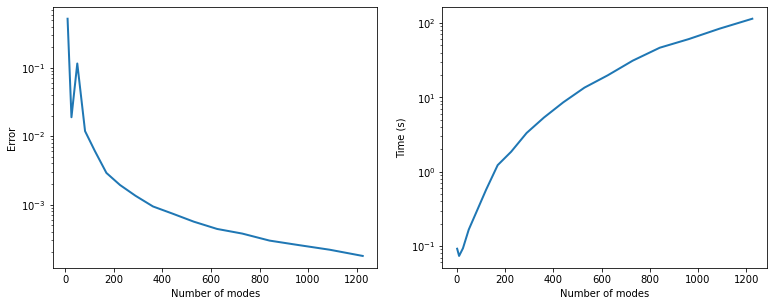

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=[12.8, 4.8])
ni = np.arange(1, N_max + 1, 2) ** 2

ax[0].semilogy(ni[1:], np.abs(np.diff(RT[0])), linewidth=2)
ax[0].set_xlabel('Number of modes')
ax[0].set_ylabel('Error')

ax[1].semilogy(ni, tt, linewidth=2)
ax[1].set_xlabel('Number of modes')
ax[1].set_ylabel('Time (s)')
plt.show()

## FFT

The scaling of the FFT can be obtained through the `Layer.fft_convergence` method which returns a tuple of the time taken for each computation and the maximum difference in the norms of the FFT matrices compared to the previous computation.

#### Parameters
- `max_res`: The maximum resolution to compute the FFT for.
- `n_res`: The number of steps in the resolution from the minimum i.e. $2N-1$ to `max_res`.
- `N`: Defines the minimum resolution and truncates the central $2N-1$ orders from the FFT solution.
- `period`: The period of the lattice. Increasing the period will also increase size of grid if resolution is constant.
- `n_iter=3`: The number of computations over which the time is averaged.

In [10]:
m_res = 1e4
n = 50
N = 9
(err, T) = phc.fft_convergence(m_res, n, N, p)

Comp. 1: res = (216.66, 216.66)
Time = 0.034, diff = 5.05139
Comp. 2: res = (416.32, 416.32)
Time = 0.088, diff = 0.10159
Comp. 3: res = (615.98, 615.98)
Time = 0.088, diff = 0.36735
Comp. 4: res = (815.64, 815.64)
Time = 0.141, diff = 0.09474
Comp. 5: res = (1015.3, 1015.3)
Time = 0.355, diff = 0.0583
Comp. 6: res = (1214.96, 1214.96)
Time = 0.251, diff = 0.14738
Comp. 7: res = (1414.62, 1414.62)
Time = 0.667, diff = 0.05775
Comp. 8: res = (1614.28, 1614.28)
Time = 0.515, diff = 0.04061
Comp. 9: res = (1813.94, 1813.94)
Time = 1.228, diff = 0.09882
Comp. 10: res = (2013.6, 2013.6)
Time = 1.042, diff = 0.04978
Comp. 11: res = (2213.2599999999998, 2213.2599999999998)
Time = 1.013, diff = 0.02865
Comp. 12: res = (2412.92, 2412.92)
Time = 2.132, diff = 0.07216
Comp. 13: res = (2612.58, 2612.58)
Time = 1.753, diff = 0.03056
Comp. 14: res = (2812.24, 2812.24)
Time = 2.574, diff = 0.02945
Comp. 15: res = (3011.9, 3011.9)
Time = 2.812, diff = 0.05799
Comp. 16: res = (3211.56, 3211.56)
Time = 

Since the values are stored, the scaling and accuracy can be quickly visualized.

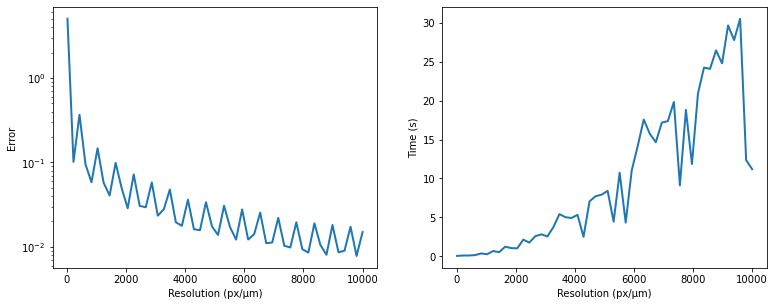

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=[12.8, 4.8])
ri = np.linspace(2 * N - 1, m_res, n)

ax[0].semilogy(ri, err, linewidth=2)
ax[0].set_xlabel('Resolution (px/μm)')
ax[0].set_ylabel('Error')

ax[1].plot(ri, T, linewidth=2)
ax[1].set_xlabel('Resolution (px/μm)')
ax[1].set_ylabel('Time (s)')
plt.show()